# Basic protein Folding with PyRosetta

In [1]:
import pyrosetta; pyrosetta.init()
from pyrosetta import *
from pyrosetta.teaching import *
init()

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python312.Release 2024.19+release.a34b73c40fe9c61558d566d6a63f803cfb15a4fc 2024-05-02T16:22:03] retrieved from: http://www.pyrosetta.org
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.conda.linux.cxx11thread.seria

## Building the Pose

In this workshop, you will be folding a 10 residue protein by building a simple de novo folding algorithm. Start by initializing PyRosetta as usual.

Create a simple poly-alanine `pose` with 10 residues for testing your folding algorithm. Store the pose in a variable called "polyA."

In [2]:
polyA = pyrosetta.pose_from_sequence('A' * 10)

polyA.pdb_info().name("polyA")

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 985 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.896394 seconds.


Check the backbone dihedrals of a few residues (except the first and last) using the `.phi()` and `.psi()` methods in `Pose`.

In [3]:
print("phi of residue 9: %i" % polyA.phi(9))
print("psi of residue 9: %i" % polyA.psi(9))
print("omega of residue 9: %i" % polyA.omega(9))
print("Total residues: %i" % polyA.total_residue())
print("Sequence: %s" % polyA.sequence())
print("PDB info name: %s" % polyA.pdb_info().name())

phi of residue 9: 180
psi of residue 9: 180
omega of residue 9: 180
Total residues: 10
Sequence: AAAAAAAAAA
PDB info name: polyA


## OPTIONAL pymol visualization

We may want to visualize folding as it happens. Before starting with the folding protocol, instantiate a PyMOL mover and use a UNIQUE port number between 10,000 and 65,536. We will retain history in order to view the entire folding process by utilizing the `.keep_history()` method. Make sure it says `PyMOL <---> PyRosetta link started!` on its command line.

In [4]:
pmm = PyMOLMover()
pmm.keep_history(True)


Use the PyMOL mover to view the `polyA` `Pose`. You should see a long thread-like structure in PyMOL.

In [5]:
pmm.apply(polyA)

## Building A Basic *de Novo* Folding Algorithm

Now, write a program that implements a Monte Carlo algorithm to optimize the protein conformation. You can do this here in the notebook, or you may use a code editor to write a `.py` file and execute in a Python or iPython shell.  

Our main program will include 100 iterations of making a random trial move, scoring the protein, and accepting/rejecting the move. Therefore, we can break this algorithm down into three smaller subroutines: **random, score, and decision.**

### Step 1: Random Move

For the **random** trial move, write a subroutine to choose one residue at random using `random.randint()` and then randomly perturb either the φ or ψ angles by a random number chosen from a Gaussian distribution. Use the Python built-in function `random.gauss()` from the `random` library with a mean of the current angle and a standard deviation of 25°. After changing the torsion angle, use `pmm.apply(polyA)` to update the structure in PyMOL.

In [6]:
import math
import random

def randTrial(your_pose):
    randNum = random.randint(2, your_pose.total_residue())
    currPhi = your_pose.phi(randNum)
    currPsi = your_pose.psi(randNum)
    newPhi = random.gauss(currPhi, 25)
    newPsi = random.gauss(currPsi, 25)
    your_pose.set_phi(randNum,newPhi)
    your_pose.set_psi(randNum,newPsi)
    pmm.apply(your_pose)
    return your_pose

### Step 2: Scoring Move

For the **scoring** step, we need to create a scoring function and make a subroutine that simply returns the numerical energy score of the pose.

In [7]:
sfxn = get_fa_scorefxn()

def score(your_pose):
    return sfxn(your_pose)

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
basic.io.database: Database file opened: scoring/score_functions/rama/fd/

In PyRosetta the score of a protein pose is calculated using a scoring function, which is a weighted sum of various energy terms. These energy terms represent different physical and statistical properties of the protein structure, such as van der Waals interactions, hydrogen bonding, electrostatics, solvation, and torsional angles.

The full-atom scoring function (`fa_scorefxn`) typically includes terms like:

- `fa_atr`: Attractive van der Waals forces
- `fa_rep`: Repulsive van der Waals forces
- `fa_sol`: Solvation energy
- `fa_intra_rep`: Intra-residue repulsive forces
- `fa_elec`: Electrostatic interactions
- `hbond_sr_bb`: Short-range backbone hydrogen bonding
- `hbond_lr_bb`: Long-range backbone hydrogen bonding
- `hbond_bb_sc`: Backbone-sidechain hydrogen bonding
- `hbond_sc`: Sidechain-sidechain hydrogen bonding
- `rama`: Ramachandran preferences
- `omega`: Omega torsion
- `fa_dun`: Dunbrack rotamer library
- `p_aa_pp`: Probability of amino acid given phi/psi

The scoring function assigns a weight to each of these terms and computes the total score as the weighted sum of all these individual energy terms.

In [8]:
polyA.energies().show()

core.scoring.Energies: E


### Step 3: Accepting/Rejecting Move
For the **decision** step, we need to make a subroutine that either accepts or rejects the new conformation based on the Metropolis criterion. The Metropolis criterion has a probability of accepting a move as $P = \exp( -\Delta G / kT )$. When $ΔE ≥ 0$, the Metropolis criterion probability of accepting the move is $P = \exp( -\Delta G / kT )$. When $ΔE < 0$, the Metropolis criterion probability of accepting the move is $P = 1$. Use $kT = 1$ Rosetta Energy Unit (REU).

In [9]:
def decision(before_pose, after_pose):
    E = score(after_pose) - score(before_pose)
    if E < 0:
        return after_pose
    elif random.uniform(0, 1) >= math.exp(-E/1):
        return before_pose
    else:
        return after_pose


## Execution
Now we can put these three subroutines together in our main program! Write a loop in the main program so that it performs 100 iterations of: making a random trial move, scoring the protein, and accepting/rejecting the move.

After each iteration of the search, output the current pose energy and the lowest energy ever observed. **The final output of this program should be the lowest energy conformation that is achieved at *any* point during the simulation.** Be sure to use `low_pose.assign(pose)` rather than `low_pose = pose`, since the latter will only copy a pointer to the original pose.

In [10]:
def basic_folding(your_pose, num_iterations=10000):
    """basic folding algorithm that completes Monte-Carlo iterations on a given pose"""

    lowest_pose = Pose() # Create an empty pose for tracking the lowest energy pose.
    lowest_pose.assign(your_pose)
    lowest_score = score(lowest_pose)

    scores = []  # List to keep track of scores

    for i in range(num_iterations):
        before_pose = Pose()
        before_pose.assign(your_pose) # keep track of pose before random move

        after_pose = Pose()
        after_pose.assign(randTrial(your_pose)) # do random move and store the pose

        your_pose.assign(decision(before_pose, after_pose)) # keep the new pose or old pose

        current_score = score(your_pose)
        scores.append(current_score)

        if current_score < lowest_score: # updating lowest pose
            lowest_pose.assign(your_pose)
            lowest_score = current_score

        if (i + 1) % 100 == 0:  # Print info every 100 iterations
            print(f"Iteration # {i + 1}")
            print(f"Current pose score: {current_score:.3f}")
            print(f"Lowest pose score: {lowest_score:.3f}")

    return lowest_pose, scores

In [11]:
pose, scores = basic_folding(polyA)

basic.io.database: Database file opened: scoring/score_functions/elec_cp_reps.dat
core.scoring.elec.util: Read 40 countpair representative atoms
core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /home/ma/miniconda3/envs/rosetta/lib/python3.12/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/home/ma/miniconda3/envs/rosetta/lib/python3.12/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0.254088 seconds to load from binary
Iteration # 100
Current pose score: 10.628
Lowest pose score: 10.114
Iteration # 200
Current pose score: 14.664
Lowest pose score: 8.932
Iteration # 300
Cur

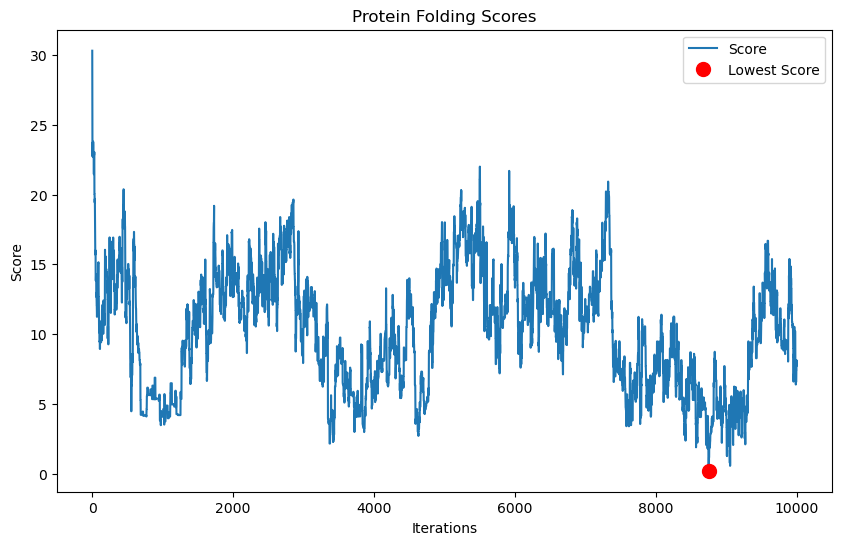

In [12]:
import matplotlib.pyplot as plt
iterations = list(range(1, len(scores) + 1))
plt.figure(figsize=(10, 6))
plt.plot(iterations, scores, label='Score')

# Find the index of the lowest score
lowest_score_index = scores.index(min(scores))

# Plot the lowest score point with a red dot
plt.plot(iterations[lowest_score_index], scores[lowest_score_index], 'ro', markersize=10, label='Lowest Score')

plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Protein Folding Scores');

In [13]:
# Save the lowest score pose to PDB file
pose.dump_pdb("lowest_score_pose.pdb")
print("Lowest score pose saved to 'lowest_score_pose.pdb'")

Lowest score pose saved to 'lowest_score_pose.pdb'


note: the proposal mechanism, being based on random perturbation followed by MH acceptance, is not efficient for sampling low energy conformations. Many possible improvements are possible. 